In [1]:
import sys
sys.path.extend(['../', '../ML_Models/'])

# Disable annoying warnings
import warnings
warnings.filterwarnings('ignore')

# Essentials
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import minimize

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

# Custom
from analysis_simulation import *
from ML_Models.classifiers import *


file_pPs = "../data/txt_files/TwoGamma_10M.txt"
file_oPs = "../data/txt_files/ThreeGamma_10M.txt"
file_oPs_processed = "../data/txt_files/ThreeGamma_processed.txt"

In [2]:
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['legend.fontsize'] = 14

## Part 1: Plotting 2D Histogram

In [3]:
An = SimulationAnalyzer(file_pPs, file_oPs)
smearing_params = {'smearing': 0.08, 'reference_energy': 662, 'type': 'FWHM'}
An.full_process(smearing_params=smearing_params, crystal_window=[0.01, 1000], module_window=[0.01, 1000], coincidence=True, integration_mode="module")
n_pPs = An.n_pPs
n_oPs = An.n_oPs

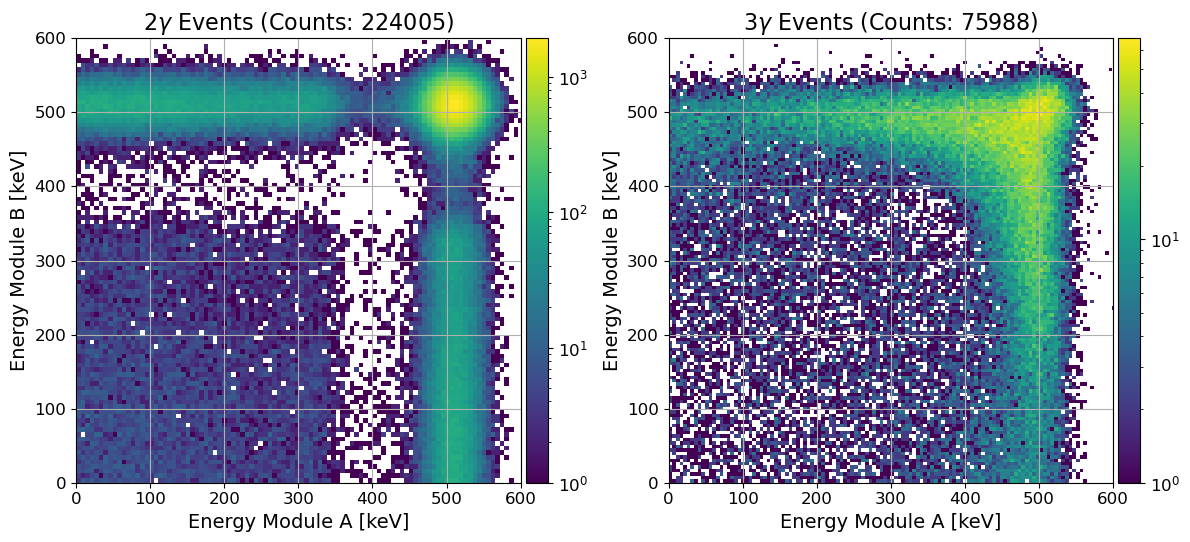

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Heatplot 1
h1 = ax[0].hist2d(An.energy_pPs_p[:, 0], An.energy_pPs_p[:, 1], bins=(150, 150), norm=LogNorm())
ax[0].set_title(rf'$2\gamma$ Events (Counts: {An.n_pPs})')
ax[0].set_xlabel('Energy Module A [keV]')
ax[0].set_ylabel('Energy Module B [keV]')
ax[0].grid()
ax[0].set_xlim(0, 600)
ax[0].set_ylim(0, 600)
ax[0].set_aspect('equal', adjustable='box')
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h1[3], cax=cax1)

# Heatplot 2
h2 = ax[1].hist2d(An.energy_oPs_p[:, 0], An.energy_oPs_p[:, 1], bins=(150, 150), norm=LogNorm())
ax[1].set_title(rf'$3\gamma$ Events (Counts: {An.n_oPs})')
ax[1].set_xlabel('Energy Module A [keV]')
ax[1].set_ylabel('Energy Module B [keV]')
ax[1].grid()
ax[1].set_xlim(0, 600)
ax[1].set_ylim(0, 600)
ax[1].set_aspect('equal', adjustable='box')
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h2[3], cax=cax2)

plt.tight_layout()
plt.show()

# Part 2: Increasing $\eta$ Using Cut-Based Approach

In [6]:
def compute(cr_cut, mod_cut):
    An.reset()
    An.apply_smearing(0.05)
    An.apply_crystal_cut([cr_cut, 1000])
    An.apply_module_cut([mod_cut, 1000], coincidence=True)
    return An.n_pPs/n_pPs, An.n_oPs/n_oPs, An.n_pPs/An.n_oPs


crystal_cuts = [0.01, 100, 100, 100, 400, 450, 480]
module_cuts = [0.01, 400, 450, 480, 400, 450, 480]


for (cr_cut, mod_cut) in zip(crystal_cuts, module_cuts):
    # Format as latex table
    eta_pPs, eta_oPs, eta_ratio = compute(cr_cut, mod_cut)
    print(f"{cr_cut} & {mod_cut} & {1e2*eta_pPs:.2f} & {1e2*eta_oPs:.2f} & {eta_ratio:.2f} \\\\")

0.01 & 0.01 & 100.03 & 100.04 & 2.95 \\
100 & 400 & 56.71 & 28.08 & 5.95 \\
100 & 450 & 49.57 & 12.80 & 11.41 \\
100 & 480 & 44.25 & 6.05 & 21.58 \\
400 & 400 & 23.21 & 11.02 & 6.21 \\
450 & 450 & 19.96 & 3.82 & 15.41 \\


## Part 3: Using Output of Cut-Based Approach for Fine-Tuning

In [108]:
crystal_cuts = [1, 100, 100, 100, 400, 450, 480]
module_cuts = [1, 400, 450, 480, 400, 450, 480]


GBDT = BDT_Classifier(boosting_mode='xgb', n_estimators=100, max_depth=3, learning_rate=0.1)
ABDT = BDT_Classifier(boosting_mode='ada', n_estimators=50, max_depth=1, learning_rate=1)
NN = NN_Classifier(architecture=[256, 100, 100, 1])
models = [GBDT, ABDT, NN]

In [164]:
An1 = SimulationAnalyzer(file_pPs, file_oPs)
An2 = SimulationAnalyzer(file_pPs, file_oPs_processed)

pca = PCA(n_components=256)
results_after_all = []
SEs_before = []
BEs_before = []
SBs_before = []
ROC_scores = []


def split_data_even_training(X, y, train_size):
    X_pPs = X[y==1]
    n_pPs = len(X_pPs)
    X_oPs = X[y==0]
    n_oPs = len(X_oPs)
    X_train = np.concatenate([X_pPs[:train_size], X_oPs[:train_size]])
    y_train = np.concatenate([np.ones(train_size), np.zeros(train_size)])
    X_test = np.concatenate([X_pPs[train_size:], X_oPs[train_size:]])
    y_test = np.concatenate([np.ones(n_pPs-train_size), np.zeros(n_oPs-train_size)])
    idx_train = np.random.permutation(len(X_train))
    idx_test = np.random.permutation(len(X_test))
    X_train = X_train[idx_train]
    y_train = y_train[idx_train]
    X_test = X_test[idx_test]
    y_test = y_test[idx_test]
    return X_train, X_test, y_train, y_test


def balanced_train_test_split(X, y, n_train, n_test):
    idx_shuffle = np.random.permutation(len(X))
    X = X[idx_shuffle]
    y = y[idx_shuffle]

    X_pPs = X[y == 1]
    X_oPs = X[y == 0]
    
    # Randomly select balanced subsets for training and test sets
    X_train_pPs, X_test_pPs = train_test_split(X_pPs, train_size=n_train//2, test_size=n_test//2, random_state=42)
    y_train_pPs, y_test_pPs = np.ones(len(X_train_pPs)), np.ones(len(X_test_pPs))
    X_train_oPs, X_test_oPs = train_test_split(X_oPs, train_size=n_train//2, test_size=n_test//2, random_state=42)
    y_train_oPs, y_test_oPs = np.zeros(len(X_train_oPs)), np.zeros(len(X_test_oPs))

    # Combine the subsets to create the final training and test sets
    X_train = np.concatenate((X_train_pPs, X_train_oPs), axis=0)
    y_train = np.concatenate((y_train_pPs, y_train_oPs), axis=0)
    X_test = np.concatenate((X_test_pPs, X_test_oPs), axis=0)
    y_test = np.concatenate((y_test_pPs, y_test_oPs), axis=0)
    
    # Shuffle the final training and test sets
    idx_train = np.random.permutation(len(X_train))
    idx_test = np.random.permutation(len(X_test))
    X_train = X_train[idx_train]
    y_train = y_train[idx_train]
    X_test = X_test[idx_test]
    y_test = y_test[idx_test]
    
    return X_train, X_test, y_train, y_test


for i, (E_crystal, E_module) in enumerate(zip(crystal_cuts, module_cuts)):
    print(f"Working on {i}. iteration")

    result = []
    An1.reset()
    An2.reset()
    
    # Prepare data
    An1.full_process(smearing=0.05, crystal_window=[E_crystal, 1000], module_window=[E_module, 1000], coincidence=True, integration_mode=None)
    X1, y1 = An1.get_data(preprocessed=True, balanced=True)

    if i in [3, 5, 6]:
        An2.full_process(smearing=0.05, crystal_window=[E_crystal, 1000], module_window=[E_module, 1000], coincidence=True, integration_mode=None)
        X, y = An2.get_data(preprocessed=True, balanced=True)
        print(An2.n_pPs, An2.n_oPs)
    else:
        X, y = X1, y1
        print(An1.n_pPs, An1.n_oPs)

    pca.fit(X)
    X = pca.transform(X)
    X = (X-np.mean(X, axis=0))/np.std(X, axis=0)

    # Problem: Can set train_size only to 500 because of limited data size for certain cuts -> MLP does not converge
    # X_train, X_test, y_train, y_test = split_data_even_training(X, y, train_size=500)
    X_train, X_test, y_train, y_test = balanced_train_test_split(X, y, n_train=10_000, n_test=2_000)
    
    # Compute SB ratio before ML
    SB_before = An1.n_pPs/An1.n_oPs
    SE_before = An1.n_pPs/An1.n_pPs_raw
    BE_before = An1.n_oPs/An1.n_oPs_raw

    ROCs = np.zeros(3)

    # Train models
    for i, model in enumerate(models):
        model.train(X_train, y_train)
        y_pred = model.predict(X_test, threshold=0.5)
        cm = confusion_matrix(y_pred, y_test)
        BE_after = cm[1, 0]/(cm[1, 0]+cm[0, 0])
        SE_after = cm[1, 1]/(cm[0, 1]+cm[1, 1])
        SB_after = SE_after/BE_after
        model_result = [SE_after, BE_after, SB_after]
        result.append(model_result)
        ROCs[i] = model.get_auc(X_test, y_test)

    # Append results
    results_after_all.append(result)
    SEs_before.append(SE_before)
    BEs_before.append(BE_before)
    SBs_before.append(SB_before)
    ROC_scores.append(ROCs)


# Convert to np.ndarray
results_after_all = np.array(results_after_all)
SEs_before = np.array(SEs_before) 
BEs_before = np.array(BEs_before)
SBs_before = np.array(SBs_before)
ROC_scores = np.array(ROC_scores)

Working on 0. iteration
223800 75925
Working on 1. iteration
126201 21014
Working on 2. iteration
109509 9386
Working on 3. iteration
83879 80438
Working on 4. iteration
51970 8270
Working on 5. iteration
43965 42856
Working on 6. iteration
33028 15718


In [113]:
# Best result by SB ratio
SEs_max = results_after_all.max(axis=1)[:, 0]
BEs_max = results_after_all.max(axis=1)[:, 1]
SBs_max = results_after_all.max(axis=1)[:, 2]

SEs_tot_max = SEs_max*SEs_before
BEs_tot_max = BEs_max*BEs_before
SBs_tot_max = SBs_max*SBs_before


# GBDT results
SEs_GBDT = results_after_all[:, 0, 0]
BEs_GBDT = results_after_all[:, 0, 1]
SBs_GBDT = results_after_all[:, 0, 2]

SEs_tot_GBDT = SEs_GBDT*SEs_before
BEs_tot_GBDT = BEs_GBDT*BEs_before
SBs_tot_GBDT = SBs_GBDT*SBs_before


# ABDT results
SEs_ABDT = results_after_all[:, 1, 0]
BEs_ABDT = results_after_all[:, 1, 1]
SBs_ABDT = results_after_all[:, 1, 2]

SEs_tot_ABDT = SEs_ABDT*SEs_before
BEs_tot_ABDT = BEs_ABDT*BEs_before
SBs_tot_ABDT = SBs_ABDT*SBs_before


# NN results
SEs_NN = results_after_all[:, 2, 0]
BEs_NN = results_after_all[:, 2, 1]
SBs_NN = results_after_all[:, 2, 2]

SEs_tot_NN = SEs_NN*SEs_before
BEs_tot_NN = BEs_NN*BEs_before
SBs_tot_NN = SBs_NN*SBs_before


# Latex table for GBDT
print('Results for no ML and GBDT:')
for (E_crystal, E_module, SE_before, BE_before, SE_tot, BE_tot) in zip(crystal_cuts, module_cuts, SEs_before, BEs_before, SEs_tot_GBDT, BEs_tot_GBDT):
    print(f"{E_crystal} & {E_module} & {100*SE_before:.2f} & {100*BE_before:.2f} & {100*SE_tot:.2f} & {100*BE_tot:.2f} \\\\")
    print('\hline')

print('\nResults for ABDT and NN:')
# Latex table for ABDT
for (E_crystal, E_module, SE_tot_ABDT, BE_tot_ABDT, SE_tot_NN, BE_tot_NN) in zip(crystal_cuts, module_cuts, SEs_tot_ABDT, BEs_tot_ABDT, SEs_tot_NN, BEs_tot_NN):
    print(f"{E_crystal} & {E_module} & {100*SE_tot_ABDT:.2f} & {100*BE_tot_ABDT:.2f} & {100*SE_tot_NN:.2f} & {100*BE_tot_NN:.2f} \\\\")
    print('\hline')

Results for no ML and GBDT:
1 & 1 & 40.18 & 6.77 & 33.11 & 1.23 \\
\hline
100 & 400 & 22.61 & 1.86 & 18.04 & 0.50 \\
\hline
100 & 450 & 19.63 & 0.85 & 15.05 & 0.24 \\
\hline
100 & 480 & 15.04 & 0.38 & 10.92 & 0.11 \\
\hline
400 & 400 & 9.32 & 0.74 & 7.81 & 0.11 \\
\hline
450 & 450 & 7.87 & 0.26 & 6.50 & 0.06 \\
\hline
480 & 480 & 5.93 & 0.08 & 4.97 & 0.02 \\
\hline

Results for ABDT and NN:
1 & 1 & 30.86 & 1.39 & 33.31 & 3.49 \\
\hline
100 & 400 & 17.41 & 0.54 & 18.99 & 0.88 \\
\hline
100 & 450 & 14.11 & 0.25 & 16.43 & 0.45 \\
\hline
100 & 480 & 10.10 & 0.11 & 12.54 & 0.24 \\
\hline
400 & 400 & 7.79 & 0.13 & 8.22 & 0.22 \\
\hline
450 & 450 & 6.47 & 0.06 & 6.92 & 0.10 \\
\hline
480 & 480 & 4.80 & 0.02 & 5.24 & 0.04 \\
\hline


In [135]:
# Full classifier ROC curve for GBDT
An_model = SimulationAnalyzer(file_pPs, file_oPs_processed)
An_model.full_process(smearing=0.05, crystal_window=[480, 1000], module_window=[480, 1000], coincidence=True, integration_mode=None)
X, y = An_model.get_data(preprocessed=True, balanced=True)
pca.fit(X)
X = pca.transform(X)
X = (X-np.mean(X, axis=0))/np.std(X, axis=0)
n_sample, n_features = X.shape
print(f"Number of samples: {n_sample}, number of features: {n_features}")

Number of samples: 31280, number of features: 256


In [155]:
NN = NN_Classifier(architecture=[256, 100, 100, 1])
X_train, X_test, y_train, y_test = balanced_train_test_split(X, y, n_train=10_000, n_test=2_000)
NN.train(X_train, y_train)
fpr_before = An_model.n_oPs/An_model.n_oPs_raw
tpr_before = An_model.n_pPs/An_model.n_pPs_raw
fpr, tpr, thresholds = NN.get_roc(X_test, y_test)
auc = NN.get_auc(X_test, y_test)
fpr_total = fpr
tpr_total = tpr
cm = confusion_matrix(NN.predict(X_test, threshold=0.5), y_test)
tpr_true = cm[1, 1]/(cm[1, 1]+cm[0, 1])
fpr_true = cm[1, 0]/(cm[1, 0]+cm[0, 0])

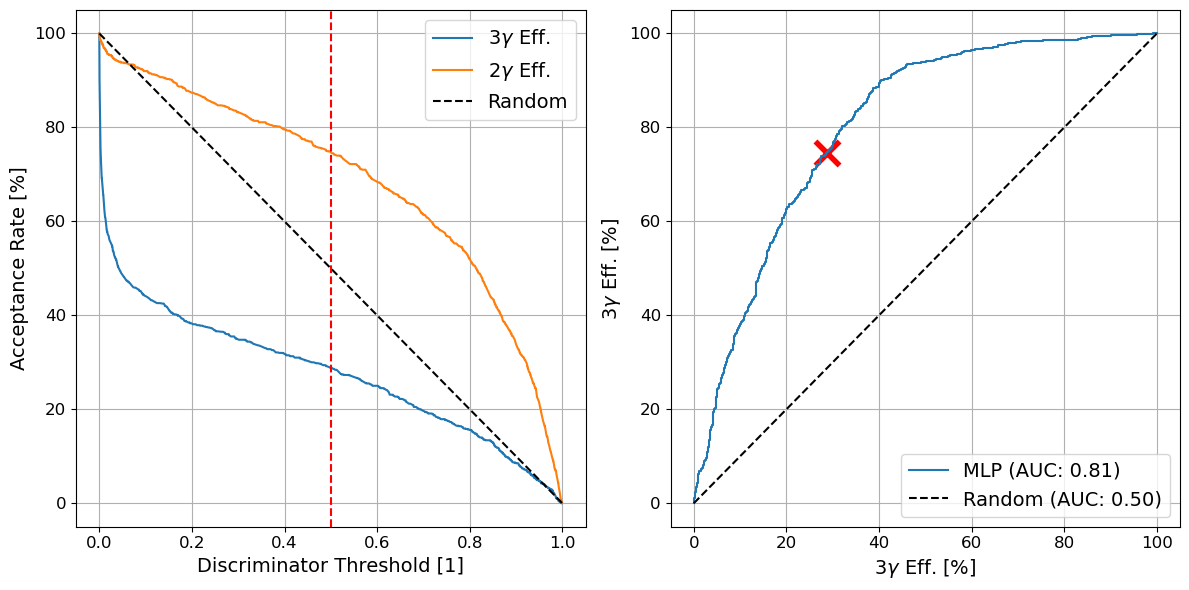

In [163]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plt.subplots_adjust(wspace=0.3)

ax[0].plot(thresholds, 100*fpr_total, label=r'$3\gamma$ Eff.')
ax[0].plot(thresholds, 100*tpr_total, label=r'$2\gamma$ Eff.')
ax[0].set_xlabel('Discriminator Threshold [1]')
ax[0].set_ylabel('Acceptance Rate [%]')
ax[0].plot([0, 1], [100, 0], 'k--', label='Random')
ax[0].axvline(0.5, color='r', linestyle='--')
# ax[0].set_yscale('log')
ax[0].grid()
ax[0].legend()

ax[1].plot(100*fpr_total, 100*tpr_total, label='MLP (AUC: {:.2f})'.format(auc))
ax[1].plot([0, 100], [0, 100], 'k--', label='Random (AUC: 0.50)')
ax[1].scatter(100*fpr_true, 100*tpr_true, color='r', marker='x', s=300, linewidth=4)
ax[1].set_xlabel(r'$3\gamma$ Eff. [%]')
ax[1].set_ylabel(r'$3\gamma$ Eff. [%]')
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()